### 전력소비량 예측 데이터 전처리 & EDA
#### 목차
1. 데이터 로드 및 전처리 (PowerUsagePreprocessor 클래스 사용)
2. 전처리된 데이터 탐색
3. EDA (Exploratory Data Analysis)
4. 전처리된 데이터 저장 및 이상치 분석

**주요 변경사항:**
- 전처리 로직을 `PowerUsagePreprocessor` 클래스로 모듈화
- 재사용 가능한 전처리 파이프라인 구축
- 자동화된 특성 엔지니어링 (시간대, 계절, 온도 카테고리 등)

##### 1. 데이터 로드

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config.config as cf
from preprocessing import PowerUsagePreprocessor

# 한글 폰트 설정
plt.rc("font", family = "Malgun Gothic")
sns.set_theme(font="Malgun Gothic")

# 전처리기 인스턴스 생성
preprocessor = PowerUsagePreprocessor()

# 데이터 불러오기
preprocessor.load_data()
train = preprocessor.train
test = preprocessor.test
building = preprocessor.building

2025-07-21 10:26:33 : INFO : [preprocessing.py:30 - load_data()] : 데이터 로딩 시작...
2025-07-21 10:26:34 : INFO : [preprocessing.py:38 - load_data()] : 데이터 로딩 완료 - Train: (204000, 10), Test: (16800, 7), Sample: (16800, 2), Building: (100, 7)


##### 2. 데이터 탐색

In [21]:
#=== Data Overview ===
print(train.shape, test.shape, sample.shape, building.shape)
print("\n칼럼명:")
print(f"train: {list(train.columns)}")
print(f"test: {list(test.columns)}")
print(f"sample: {list(sample.columns)}")
print(f"building: {list(building.columns)}")

(204000, 10) (16800, 7) (16800, 2) (100, 7)

칼럼명:
train: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
test: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
sample: ['num_date_time', 'answer']
building: ['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']


In [22]:
#=== Train Data 미리보기 ===
display(train.head())
display(train.tail())
print(train.dtypes)

num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  일조(hr)  \
0  1_20240601 00     1  20240601 00    18.3      0.0      2.6   82.0     0.0   
1  1_20240601 01     1  20240601 01    18.3      0.0      2.7   82.0     0.0   
2  1_20240601 02     1  20240601 02    18.1      0.0      2.6   80.0     0.0   
3  1_20240601 03     1  20240601 03    18.0      0.0      2.6   81.0     0.0   
4  1_20240601 04     1  20240601 04    17.8      0.0      1.3   81.0     0.0   

   일사(MJ/m2)  전력소비량(kWh)  
0        0.0     5794.80  
1        0.0     5591.85  
2        0.0     5338.17  
3        0.0     4554.42  
4        0.0     3602.25

num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)  \
203995  100_20240824 19   100  20240824 19    29.1      0.0      4.4   76.0   
203996  100_20240824 20   100  20240824 20    28.6      0.0      3.7   74.0   
203997  100_20240824 21   100  20240824 21    28.3      0.0      2.9   74.0   
203998  100_20240824 22   100  20240824 22    28.0      0.0      1.7   76.0   
203999  100_20240824 23   100  20240824 23    28.0      0.0      2.1   75.0   

        일조(hr)  일사(MJ/m2)  전력소비량(kWh)  
203995     0.4       0.18     3276.00  
203996     0.0       0.00     3197.52  
203997     0.0       0.00     3006.60  
203998     0.0       0.00     2649.72  
203999     0.0       0.00     2929.32

num_date_time     object
건물번호               int64
일시                object
기온(°C)           float64
강수량(mm)          float64
풍속(m/s)          float64
습도(%)            float64
일조(hr)           float64
일사(MJ/m2)        float64
전력소비량(kWh)       float64
dtype: object


In [23]:
#=== Test Data 미리보기 ===
display(test.head())
print(test.dtypes)

num_date_time  건물번호           일시  기온(°C)  강수량(mm)  풍속(m/s)  습도(%)
0  1_20240825 00     1  20240825 00    26.5      0.0      0.7   80.0
1  1_20240825 01     1  20240825 01    26.1      0.0      0.0   80.0
2  1_20240825 02     1  20240825 02    25.9      0.0      0.3   83.0
3  1_20240825 03     1  20240825 03    25.7      0.0      1.1   83.0
4  1_20240825 04     1  20240825 04    25.5      0.0      1.0   86.0

num_date_time     object
건물번호               int64
일시                object
기온(°C)           float64
강수량(mm)          float64
풍속(m/s)          float64
습도(%)            float64
dtype: object


In [24]:
#=== Building Data 미리보기 ===
display(building.head())
print(building.dtypes)

건물번호 건물유형    연면적(m2)   냉방면적(m2) 태양광용량(kW) ESS저장용량(kWh) PCS용량(kW)
0     1   호텔   82912.71   77586.00         -            -         -
1     2   상용   40658.90   30392.82         -            -         -
2     3   병원  560431.00  418992.00    278.58            -         -
3     4   호텔   41813.29   23715.71         -            -         -
4     5   학교  403749.39  248507.00   1983.05         1025       250

건물번호              int64
건물유형             object
연면적(m2)         float64
냉방면적(m2)        float64
태양광용량(kW)        object
ESS저장용량(kWh)     object
PCS용량(kW)        object
dtype: object


In [25]:
# 결측값 확인
print(train.isnull().sum())
print(test.isnull().sum())
print(building.isnull().sum())

num_date_time    0
건물번호             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
dtype: int64
num_date_time    0
건물번호             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
dtype: int64
건물번호            0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
dtype: int64


In [26]:
# 데이터 칼럼명 변경
preprocessor.rename_columns()
train = preprocessor.train
test = preprocessor.test
building = preprocessor.building

2025-07-21 10:26:38 : INFO : [preprocessing.py:51 - rename_columns()] : 컬럼명 영어 변환 중...
2025-07-21 10:26:38 : INFO : [preprocessing.py:60 - rename_columns()] : 컬럼명 변환 완료


In [27]:
# Object 변수 고유값 확인
for col in train.select_dtypes(include=['object']).columns:
    print(f"{col} 고유값: {train[col].unique()}")

for col in building.select_dtypes(include=['object']).columns:
    print(f"{col} 고유값: {building[col].unique()}")

num_date_time 고유값: ['1_20240601 00' '1_20240601 01' '1_20240601 02' ... '100_20240824 21'
 '100_20240824 22' '100_20240824 23']
date_time 고유값: ['20240601 00' '20240601 01' '20240601 02' ... '20240824 21' '20240824 22'
 '20240824 23']
building_type 고유값: ['호텔' '상용' '병원' '학교' '건물기타' '아파트' '연구소' '백화점' 'IDC(전화국)' '공공']
solar_capacity 고유값: ['-' '278.58' '1983.05' '389.76' '217.92' '1349.03' '276' '849.78'
 '1974.71' '97' '100' '255.88' '879.82' '858.02' '953.4' '83.95' '97.85'
 '344.96' '342' '12.24' '83.2' '74.25' '140.6' '77.76' '198.56' '10.08'
 '218.88' '1039.86' '105' '215.89' '1397.02' '199.4' '219.6' '820'
 '540.57' '50.88' '94.38' '1297.98' '1340.1' '103' '419.2' '36' '790.08'
 '605' '495' '282.95' '38.88' '77.38' '168' '322.9' '99.64' '20.25'
 '81.38' '171.6']
ess_capacity 고유값: ['-' '1025' '101.5' '500' '3100' '205' '469.2' '2000' '1670' '150' '201.1'
 '209']
pcs_capacity 고유값: ['-' '250' '101' '500' '1500' '150' '1000' '550' '75' '100']


Train data의 object 변수는 num_date_time & 일시로,
전자의 경우 고유의 ID를 나타내는 것이고,
후자는 datetime 객체로 변환할 필요가 있음.

Building data에서 수치로 보여지는 값들은 모종의 이유로 측정되지 않은 값을 ('-')로 표기하기 때문에, object가 된 것.
=> '-'를 nan으로 바꾸고, float data type으로 변환할 필요 있음.

건물유형 고유값: ['호텔' '상용' '병원' '학교' '건물기타' '아파트' '연구소' '백화점' 'IDC(전화국)' '공공']

In [28]:
preprocessor.preprocess_datetime()
preprocessor.preprocess_building_info()

train = preprocessor.train
test = preprocessor.test
building = preprocessor.building

2025-07-21 10:26:42 : INFO : [preprocessing.py:69 - preprocess_datetime()] : 날짜/시간 특성 추출 중...
2025-07-21 10:26:42 : INFO : [preprocessing.py:92 - preprocess_datetime()] : 날짜/시간 특성 추출 완료
2025-07-21 10:26:42 : INFO : [preprocessing.py:100 - preprocess_building_info()] : 건물 정보 전처리 중...
2025-07-21 10:26:42 : INFO : [preprocessing.py:111 - preprocess_building_info()] : 건물 정보 전처리 완료 - 결측값 현황:
building_num       0
building_type      0
floor_area         0
cool_area          0
solar_capacity    47
ess_capacity      88
pcs_capacity      88
dtype: int64


In [ ]:
building[building['solar_capacity'].isnull()] # 태양광이 없는 건물은 ESS와 PCS도 없는 것으로 보임

building_num building_type   floor_area    cool_area  solar_capacity  \
0              1            호텔    82912.710    77586.000             NaN   
1              2            상용    40658.900    30392.820             NaN   
3              4            호텔    41813.290    23715.710             NaN   
5              6            상용   157835.000   157835.000             NaN   
8              9            호텔   136757.000   109024.000             NaN   
9             10            호텔   435993.500   341983.000             NaN   
10            11           아파트   271233.000   233263.000             NaN   
15            16            상용    47999.000    28795.000             NaN   
16            17            병원    82573.610    68513.410             NaN   
17            18           백화점    51123.000    21751.000             NaN   
24            25           아파트   340630.000   247380.000             NaN   
26            27           백화점    66106.020    40000.000             NaN   
27            28            호텔    43894.830     5619.700             NaN   
29            30      IDC(전화국)    31156.750    13487.000             NaN   
30            31           아파트   186132.260   122153.000             NaN   
31            32           백화점    77917.000    35676.000             NaN   
34            35      IDC(전화국)    27966.920    20397.000             NaN   
35            36      IDC(전화국)    32558.000    16873.000             NaN   
39            40           백화점    57684.930    15770.320             NaN   
40            41            상용    10064.000     1862.000             NaN   
44            45           백화점   196028.200    74378.250             NaN   
45            46            학교   141963.910   135526.790             NaN   
46            47          건물기타    80337.000    66947.000             NaN   
50            51            상용    18501.000    10466.000             NaN   
53            54           백화점   133899.430    66658.000             NaN   
55            56            상용    10035.420     7593.530             NaN   
57            58          건물기타    95625.000    54824.000             NaN   
58            59           백화점   169052.000    33867.000             NaN   
60            61          건물기타    45370.540    18125.000             NaN   
61            62           연구소    66240.000    31867.000             NaN   
62            63           백화점    51771.620    12066.860             NaN   
64            65           아파트   300496.816   183315.469             NaN   
69            70           아파트   492485.514   415124.587             NaN   
70            71           아파트   228427.470   131500.000             NaN   
73            74           백화점   146518.000    98493.000             NaN   
76            77            호텔    79953.780    58489.310             NaN   
77            78          건물기타   194433.000    10435.000             NaN   
78            79           백화점   338093.000   130928.200             NaN   
80            81      IDC(전화국)    36142.330      337.840             NaN   
81            82          건물기타    83948.469    46397.000             NaN   
83            84            호텔    95232.880    23603.000             NaN   
84            85           아파트   252313.000   252257.000             NaN   
90            91           아파트   364652.770   243493.983             NaN   
92            93           아파트   308165.640    22210.390             NaN   
95            96          건물기타  3260213.410  1956128.000             NaN   
97            98            호텔    99102.620    22097.000             NaN   
99           100            호텔   162070.240   152943.000             NaN   

    ess_capacity  pcs_capacity  
0            NaN           NaN  
1            NaN           NaN  
3            NaN           NaN  
5            NaN           NaN  
8            NaN           NaN  
9            NaN           NaN  
10           NaN           NaN  
15           NaN           NaN  
16           NaN           NaN  
17           NaN         

In [ ]:
building[(building['ess_capacity'].isnull()) & (building['pcs_capacity'].isnull())] # ESS가 있으면서 PCS가 없는 건물은 없음 (vice versa)

building_num building_type  floor_area   cool_area  solar_capacity  \
0              1            호텔    82912.71    77586.00             NaN   
1              2            상용    40658.90    30392.82             NaN   
2              3            병원   560431.00   418992.00          278.58   
3              4            호텔    41813.29    23715.71             NaN   
5              6            상용   157835.00   157835.00             NaN   
..           ...           ...         ...         ...             ...   
95            96          건물기타  3260213.41  1956128.00             NaN   
96            97          건물기타    42370.93     3975.52           81.38   
97            98            호텔    99102.62    22097.00             NaN   
98            99            상용   329867.95    13442.35          171.60   
99           100            호텔   162070.24   152943.00             NaN   

    ess_capacity  pcs_capacity  
0            NaN           NaN  
1            NaN           NaN  
2            NaN           NaN  
3            NaN           NaN  
5            NaN           NaN  
..           ...           ...  
95           NaN           NaN  
96           NaN           NaN  
97           NaN           NaN  
98           NaN           NaN  
99           NaN           NaN  

[88 rows x 7 columns]

In [16]:
preprocessor.preprocess_datetime()
preprocessor.preprocess_building_info()
preprocessor.merge_data()
# preprocessor.handle_missing_values()
# preprocessor.create_features()

train = preprocessor.train
test = preprocessor.test
building = preprocessor.building

2025-07-21 10:20:18 : INFO : [preprocessing.py:69 - preprocess_datetime()] : 날짜/시간 특성 추출 중...
2025-07-21 10:20:18 : INFO : [preprocessing.py:92 - preprocess_datetime()] : 날짜/시간 특성 추출 완료
2025-07-21 10:20:18 : INFO : [preprocessing.py:100 - preprocess_building_info()] : 건물 정보 전처리 중...
2025-07-21 10:20:18 : INFO : [preprocessing.py:111 - preprocess_building_info()] : 건물 정보 전처리 완료 - 결측값 현황:
building_num       0
building_type      0
floor_area         0
cool_area          0
solar_capacity    47
ess_capacity      88
pcs_capacity      88
dtype: int64
2025-07-21 10:20:18 : INFO : [preprocessing.py:117 - merge_data()] : 데이터 병합 중...
2025-07-21 10:20:18 : INFO : [preprocessing.py:125 - merge_data()] : 데이터 병합 완료


In [ ]:
# 태양광 용량, ESS 용량, PCS 용량 결측치 어떻게 다룰까...

##### 3. EDA (Exploratory Data Analysis)

In [18]:
# 전처리된 데이터 미리보기
print("=== 전처리된 Train Data 미리보기 ===")
display(train.head())
print(f"Train 데이터 타입:\n{train.dtypes}")

print("\n=== 전처리된 Test Data 미리보기 ===") 
display(test.head())

print("\n=== 전처리된 Building Data 미리보기 ===")
display(building.head())

# 새로 생성된 특성들 확인
# print("\n=== 새로 생성된 시간 특성들 ===")
# print(f"시간대 구분 (time_period): {train['time_period'].unique()}")
# print(f"온도 카테고리 (temp_category): {train['temp_category'].unique()}")
# print(f"주말 여부 (is_weekend): {train['is_weekend'].unique()}")
# print(f"공휴일 여부 (is_holiday): {train['is_holiday'].unique()}")

=== 전처리된 Train Data 미리보기 ===


num_date_time  building_num           date_time  temperature  rain  wind  \
0  1_20240601 00             1 2024-06-01 00:00:00         18.3   0.0   2.6   
1  1_20240601 01             1 2024-06-01 01:00:00         18.3   0.0   2.7   
2  1_20240601 02             1 2024-06-01 02:00:00         18.1   0.0   2.6   
3  1_20240601 03             1 2024-06-01 03:00:00         18.0   0.0   2.6   
4  1_20240601 04             1 2024-06-01 04:00:00         17.8   0.0   1.3   

   humidity  sun  solar  power_usage  ...  day_of_week  is_weekend  day_type  \
0      82.0  0.0    0.0      5794.80  ...            5           1   weekend   
1      82.0  0.0    0.0      5591.85  ...            5           1   weekend   
2      80.0  0.0    0.0      5338.17  ...            5           1   weekend   
3      81.0  0.0    0.0      4554.42  ...            5           1   weekend   
4      81.0  0.0    0.0      3602.25  ...            5           1   weekend   

   is_holiday  building_type floor_area  cool_area solar_capacity  \
0           0             호텔   82912.71    77586.0            NaN   
1           0             호텔   82912.71    77586.0            NaN   
2           0             호텔   82912.71    77586.0            NaN   
3           0             호텔   82912.71    77586.0            NaN   
4           0             호텔   82912.71    77586.0            NaN   

   ess_capacity  pcs_capacity  
0           NaN           NaN  
1           NaN           NaN  
2           NaN           NaN  
3           NaN           NaN  
4           NaN           NaN  

[5 rows x 23 columns]

Train 데이터 타입:
num_date_time             object
building_num               int64
date_time         datetime64[ns]
temperature              float64
rain                     float64
wind                     float64
humidity                 float64
sun                      float64
solar                    float64
power_usage              float64
month                      int32
day                        int32
hour                       int32
day_of_week                int32
is_weekend                 int64
day_type                  object
is_holiday                 int64
building_type             object
floor_area               float64
cool_area                float64
solar_capacity           float64
ess_capacity             float64
pcs_capacity             float64
dtype: object

=== 전처리된 Test Data 미리보기 ===


num_date_time  building_num           date_time  temperature  rain  wind  \
0  1_20240825 00             1 2024-08-25 00:00:00         26.5   0.0   0.7   
1  1_20240825 01             1 2024-08-25 01:00:00         26.1   0.0   0.0   
2  1_20240825 02             1 2024-08-25 02:00:00         25.9   0.0   0.3   
3  1_20240825 03             1 2024-08-25 03:00:00         25.7   0.0   1.1   
4  1_20240825 04             1 2024-08-25 04:00:00         25.5   0.0   1.0   

   humidity  month  day  hour  day_of_week  is_weekend day_type  is_holiday  \
0      80.0      8   25     0            6           1  weekend           0   
1      80.0      8   25     1            6           1  weekend           0   
2      83.0      8   25     2            6           1  weekend           0   
3      83.0      8   25     3            6           1  weekend           0   
4      86.0      8   25     4            6           1  weekend           0   

  building_type  floor_area  cool_area  solar_capacity  ess_capacity  \
0            호텔    82912.71    77586.0             NaN           NaN   
1            호텔    82912.71    77586.0             NaN           NaN   
2            호텔    82912.71    77586.0             NaN           NaN   
3            호텔    82912.71    77586.0             NaN           NaN   
4            호텔    82912.71    77586.0             NaN           NaN   

   pcs_capacity  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN


=== 전처리된 Building Data 미리보기 ===


building_num building_type  floor_area  cool_area  solar_capacity  \
0             1            호텔    82912.71   77586.00             NaN   
1             2            상용    40658.90   30392.82             NaN   
2             3            병원   560431.00  418992.00          278.58   
3             4            호텔    41813.29   23715.71             NaN   
4             5            학교   403749.39  248507.00         1983.05   

   ess_capacity  pcs_capacity  
0           NaN           NaN  
1           NaN           NaN  
2           NaN           NaN  
3           NaN           NaN  
4        1025.0         250.0

예측 변수의 분포 파악

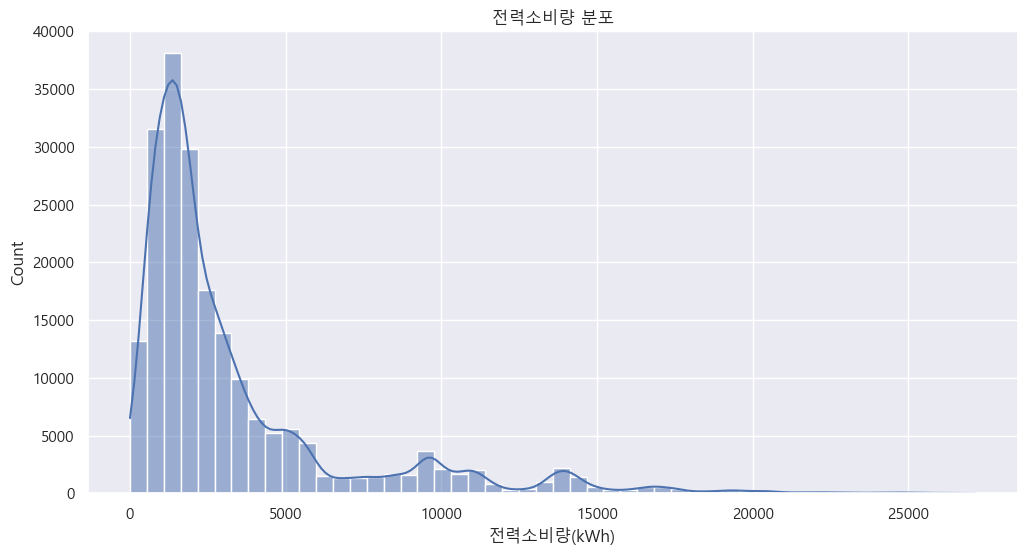

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=train, x='power_usage', bins=50, kde=True, ax=ax)
ax.set_title('전력소비량 분포')
ax.set_xlabel('power_usage')
plt.grid(True)
plt.show()

In [ ]:
# 왜곡 확인
skewness = train['power_usage'].skew()
print(f"power_usage 왜곡도: {skewness:.2f}")

전력소비량(kWh) 왜곡도: 2.32


1. 시간대 관련 가설
- 시간대별로 전력소비량은 유의하게 다를 것이다.(예: 오후 2~5시 피크 가능성)
- 주말과 평일의 전력소비량 패턴은 다를 것이다. (건물마다 다를 수도)
- 공휴일에는 전력소비량이 낮을 것이다.
- 야간(18시~06시)에는 소비량이 낮을 것이다.


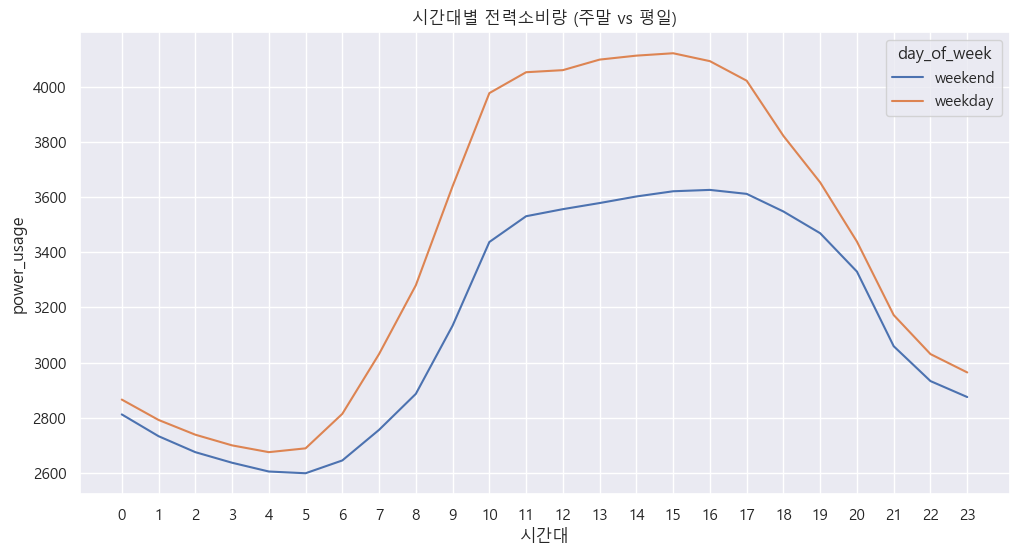

In [ ]:
# 시간대별 전력소비량
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=train, x='hour', y='power_usage', hue='day_of_week', errorbar=None, ax=ax)
ax.set_title('시간대별 전력소비량 (주말 vs 평일)')
ax.set_xlabel('시간대')
ax.set_ylabel('power_usage')
plt.xticks(range(0, 24))  # 시간대는 0~23
plt.grid(True)
plt.show()

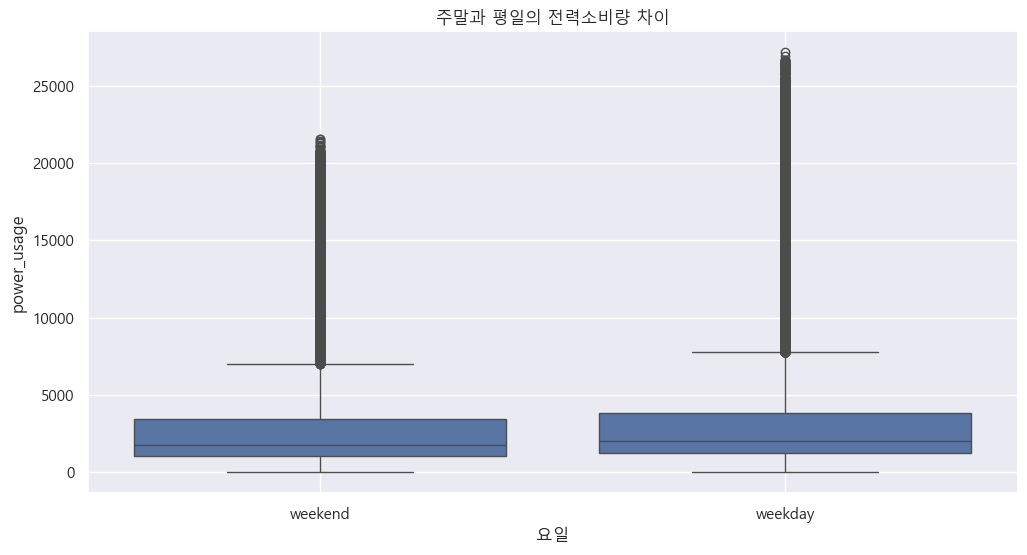

In [32]:
# 주말과 평일의 전력소비량 차이
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=train, x='day_of_week', y='power_usage', ax=ax)
ax.set_title('주말과 평일의 전력소비량 차이')
ax.set_xlabel('요일')
ax.set_ylabel('power_usage')
plt.grid(True)
plt.show()

C:\Users\wldlsyy34\AppData\Local\Temp\ipykernel_12392\4076266848.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['공휴일 X', '공휴일'])


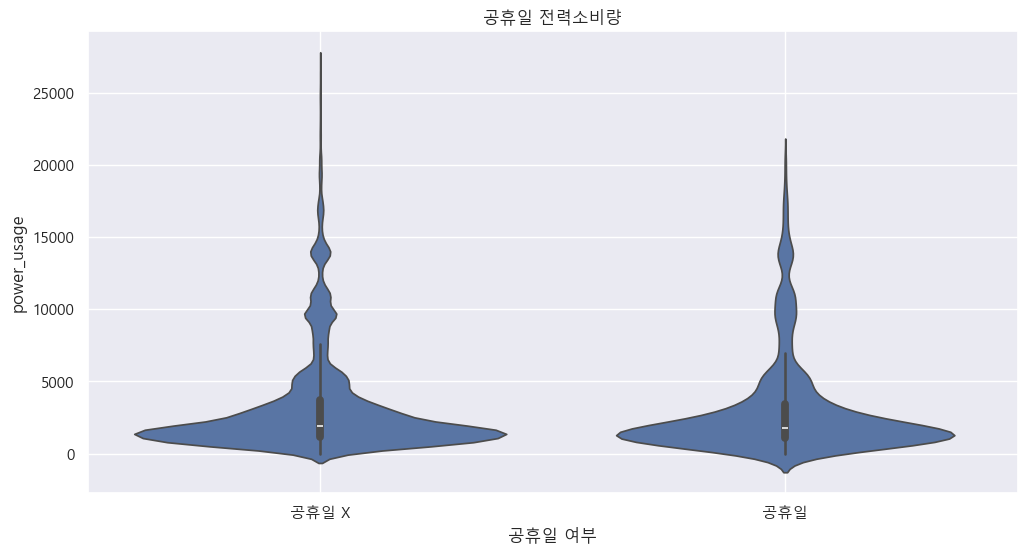

In [34]:
# 공휴일 전력소비량
is_holiday = train['date_time'].dt.date.isin([
    pd.to_datetime('2024-06-06').date(),
    pd.to_datetime('2024-08-15').date()])

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=train, x=is_holiday, y='power_usage', ax=ax)
ax.set_title('공휴일 전력소비량')
ax.set_xlabel('공휴일 여부')
ax.set_xticklabels(['공휴일 X', '공휴일'])
ax.set_ylabel('power_usage')
plt.grid(True)  
plt.show()

2. 기상 변수 관련 가설
- 기온이 높을수록 냉방 수요로 전력소비량이 증가할 것이다.
- 일사량이 높을수록 건물 내 열 축적이 커져 냉방 수요가 증가할 것이다.
- 습도가 높으면 불쾌지수 증가로 냉방 사용이 증가할 것이다.
- 풍속이 낮고 무풍상태일 경우, 열이 정체되어 냉방 수요 증가 가능성
- 비가 오는 날은 일조/일사량이 낮고 전력소비량도 낮을 것이다.

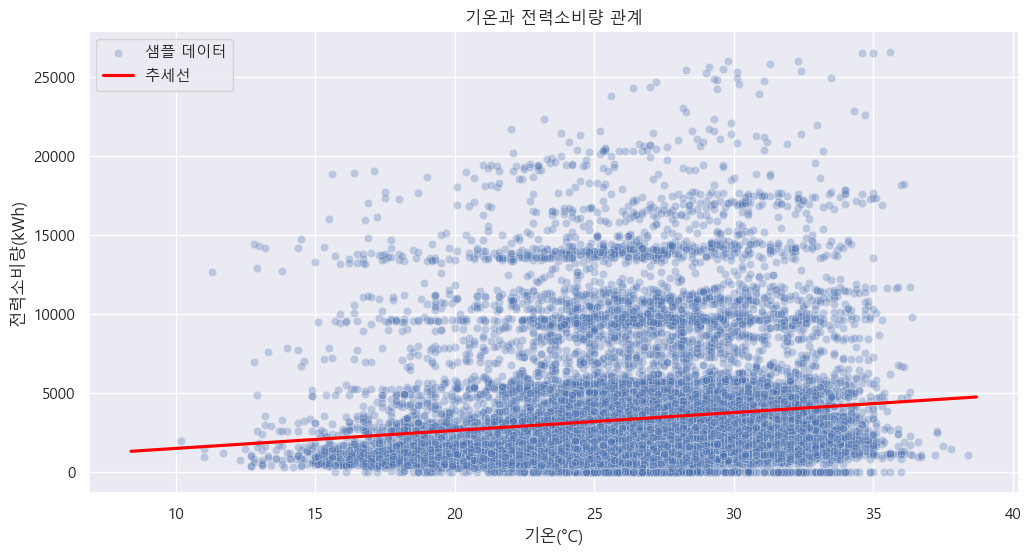

In [ ]:
# 기상변수: 기온, 강수량, 풍속, 습도, 일조, 일사
# 기온과 전력소비량 관계
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train.sample(20000),  # 샘플링으로 점 개수 줄임 (전체 데이터의 약 10%)
                x='temperature', y='power_usage', alpha=0.3, label='샘플 데이터')
sns.regplot(data=train, x='temperature', y='power_usage', 
            scatter=False, color='red', label='추세선')  # 추세선만 그리기
plt.title('기온과 전력소비량 관계')
plt.xlabel('temperature')
plt.ylabel('power_usage')
plt.grid(True)
plt.legend()
plt.show()

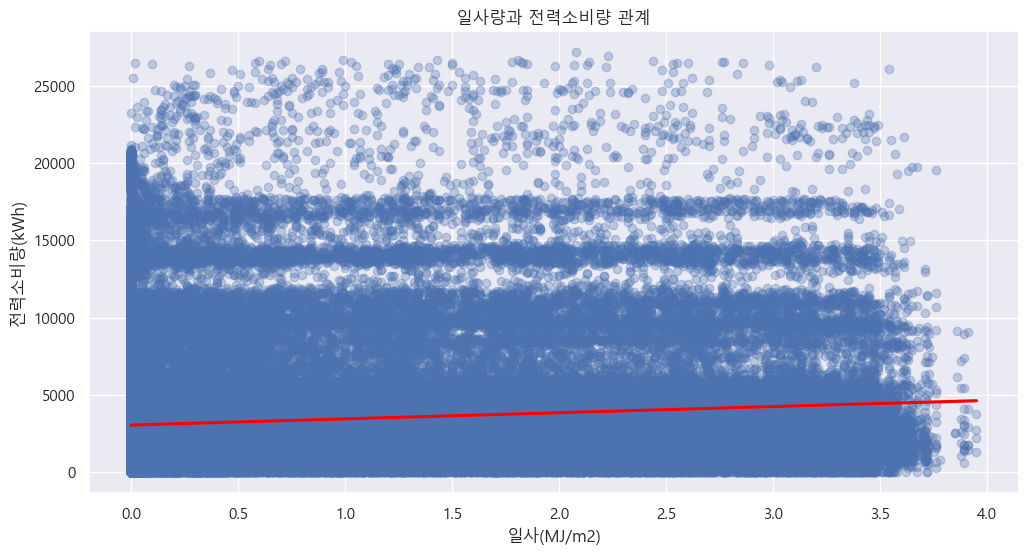

In [ ]:
# 일사량과 전력소비량 관계
plt.figure(figsize=(12, 6))
sns.regplot(data=train, x='solar', y='power_usage',
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('일사량과 전력소비량 관계')
plt.xlabel('일사(MJ/m2)')
plt.ylabel('power_usage')
plt.grid(True)
plt.show()

c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


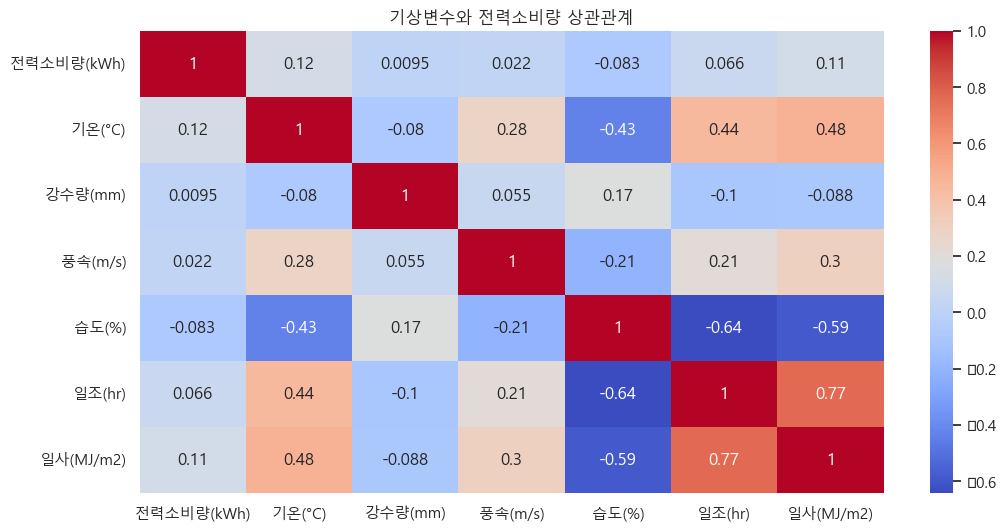

In [ ]:
# 흠냐.. 기상변수와 전력소비량 전반적인 상관관계를 보자.
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(train[['power_usage', 'temperature', 'rain', 'wind', 
                   'humidity', 'sun', 'solar']].corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('기상변수와 전력소비량 상관관계')
plt.show()

어라라ㅏ.. 생각보다 관계가 없잖아????
건물정보가 주어진거 보면.. 건물의 특성?에 따라 사용량이 달라질듯

3. 건물 속성 관련 가설
- 건물유형에 따라 전력 소비 패턴이 다를 것이다 (다중이용시설 vs 아파트)
- 연면적이 클수록 전력소비량이 클 것이다.
- 냉방면적이 클수록 여름철 전력소비량이 증가할 것이다.
- 태양광 설비가 있는 건물은 낮 시간대 소비량이 낮을 것이다.
- ESS가 있는 건물은 피크 시간대(14~17시) 전력소비량이 완화될 것이다.
- PCS 용량이 클수록 부하를 분산할 수 있어 전력소비량 변동이 적을 것이다.

In [ ]:
train['building_type'].value_counts()

건물유형
백화점         32640
호텔          20400
상용          20400
학교          20400
건물기타        20400
병원          18360
아파트         18360
연구소         18360
IDC(전화국)    18360
공공          16320
Name: count, dtype: int64

c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\wldlsyy34\AppData\Local\miniconda3\envs\ds_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


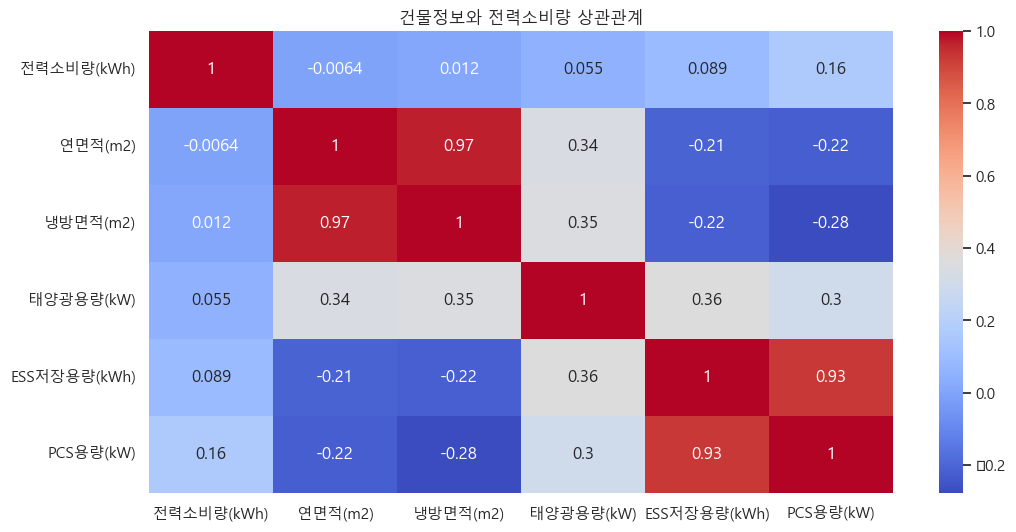

In [ ]:
# 건물 정보와 전력소비량 간의 상관관계 파악
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(train[['power_usage', 'floor_area', 'cool_area', 
                   'solar_capacity', 'ess_capacity', 'pcs_capacity']].corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('건물정보와 전력소비량 상관관계')
plt.show()

- 냉방면적과 연면적은 강한 양의 상관관계를 갖는다.
- PCS용량과 ESS저장용량은 강한 양의 상관관계를 갖는다.
- 태양광용량과 연면적은 중간 정도 양의 상관관계를 갖는다.
- 태양광용량과 냉방면적은 중간 정도 양의 상관관계를 갖는다.
- PCS용량과 냉방면적은 약한 음의 상관관계를 갖는다.

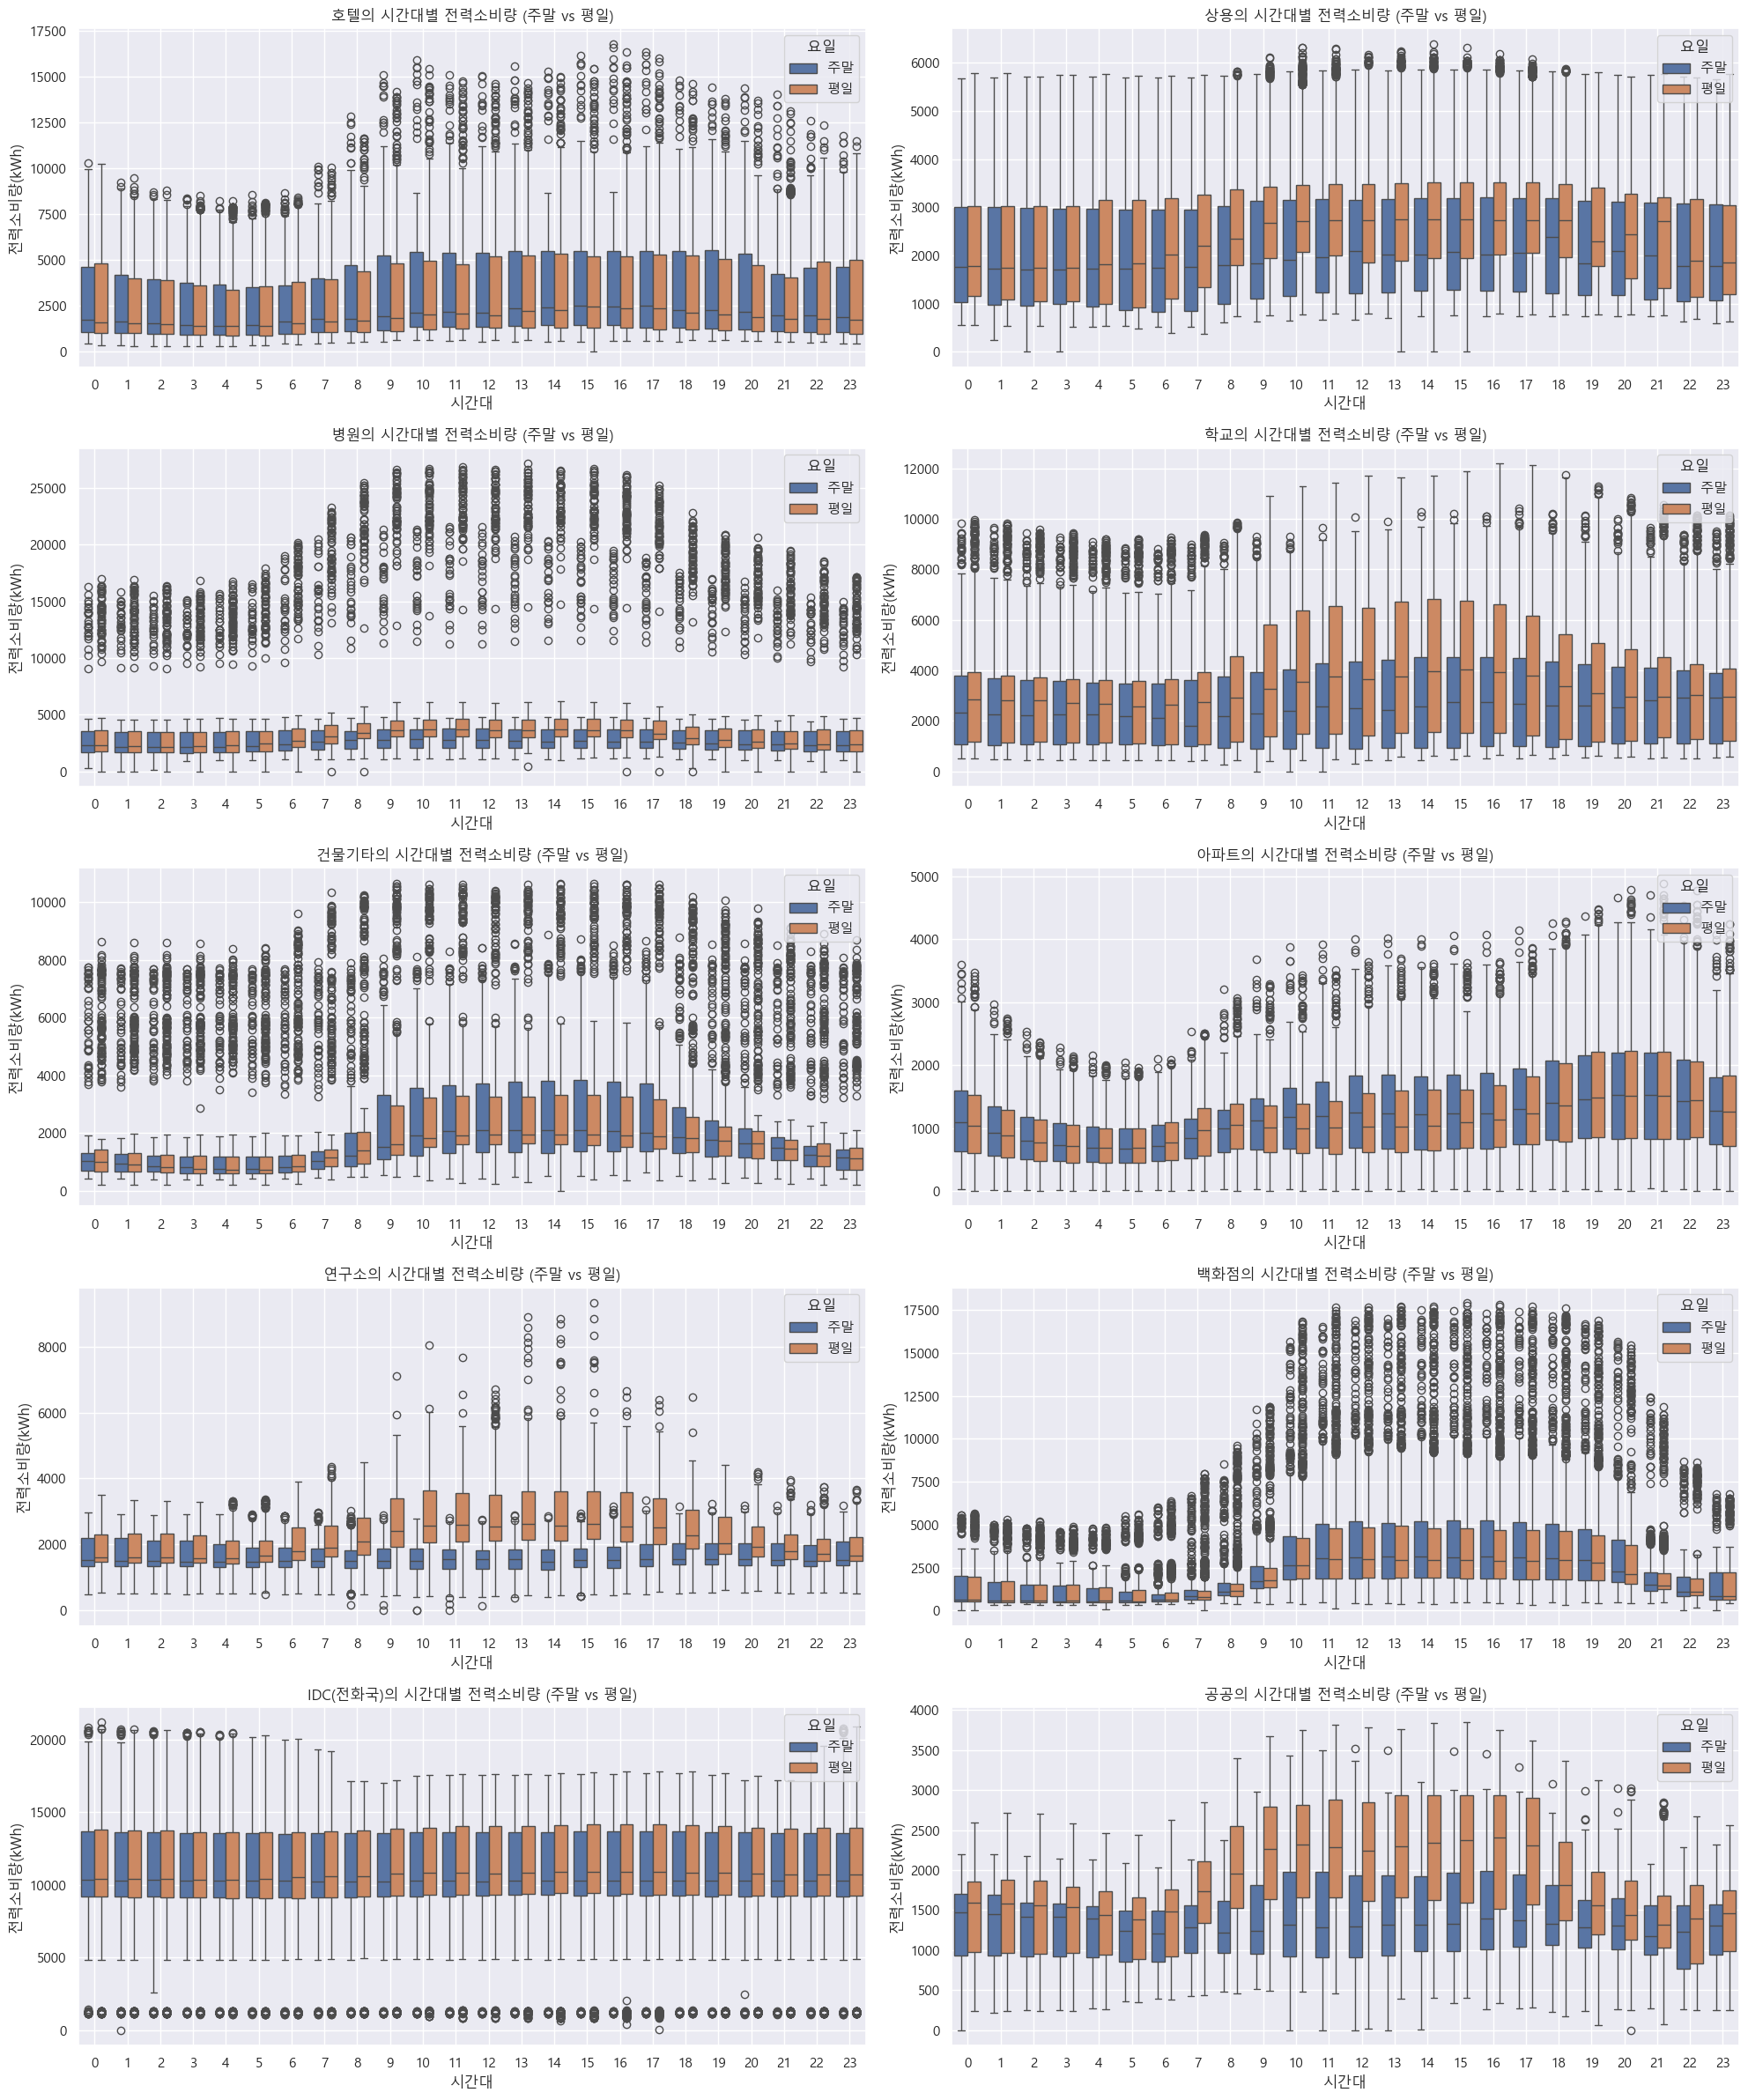

In [ ]:
# 주요 건물유형 10개별 시간대별 전력소비량 박스플롯 (5x2 서브플롯)
building_types = ['호텔', '상용', '병원', '학교', '건물기타', '아파트', '연구소', '백화점', 'IDC(전화국)', '공공']
fig, axes = plt.subplots(5, 2, figsize=(20, 24))
axes = axes.flatten()

for idx, btype in enumerate(building_types):
    data = train[train['building_type'] == btype]
    sns.boxplot(data=data, x='hour', y='power_usage', hue='day_of_week', ax=axes[idx])
    axes[idx].set_title(f"{btype}의 시간대별 전력소비량 (주말 vs 평일)")
    axes[idx].set_xlabel('시간대')
    axes[idx].set_ylabel('power_usage')
    axes[idx].grid(True)
    axes[idx].legend(title='요일', loc='upper right')

plt.tight_layout()
plt.show()

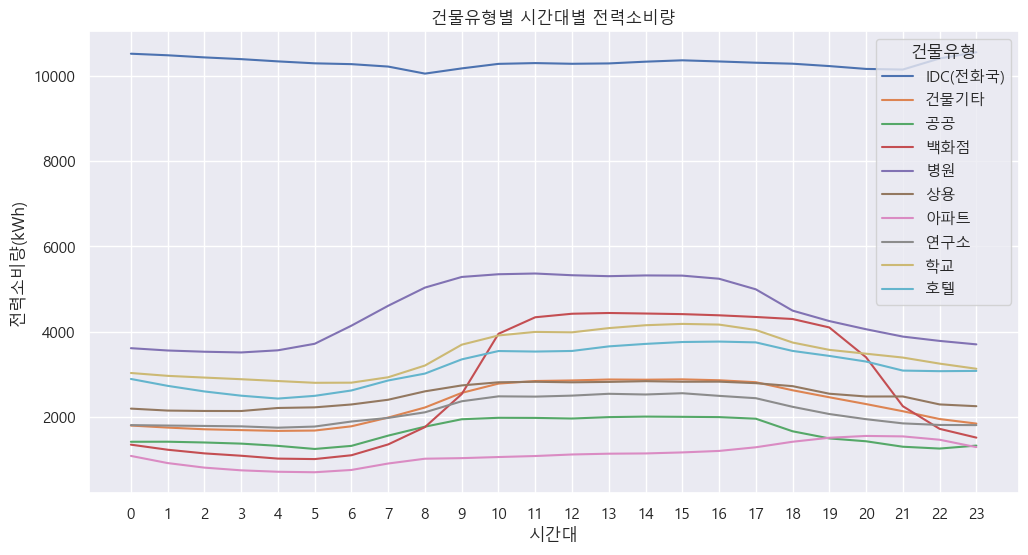

In [ ]:
# 시간대별 전력소비 패턴 비교 (building_type별)
# 건물유형별로 시간대(0~23시) 기준 평균 전력소비량 계산
building_type_hourly = train.groupby(['building_type', 'hour'])['power_usage'].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=building_type_hourly, x='hour', y='power_usage', hue='building_type', ax=ax)
ax.set_title('건물유형별 시간대별 전력소비량')
ax.set_xlabel('시간대')
ax.set_ylabel('power_usage')
plt.xticks(range(0, 24))  # 시간대는 0~23
plt.grid(True)
plt.show()

In [ ]:
train['temperature'].describe()

count    204000.000000
mean         26.098130
std           4.052888
min           8.400000
25%          23.500000
50%          26.300000
75%          28.800000
max          38.700000
Name: 기온(°C), dtype: float64

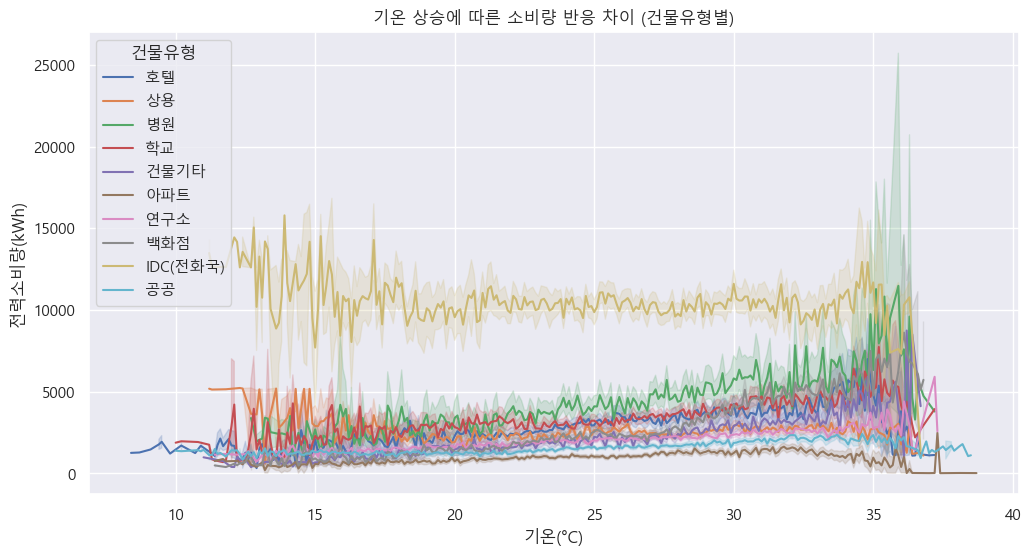

In [ ]:
# 기온 상승에 따른 소비량 반응 차이 (건물유형별)
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=train, x='temperature', y='power_usage', hue='building_type', ax=ax)
ax.set_title('기온 상승에 따른 소비량 반응 차이 (건물유형별)')
ax.set_xlabel('temperature')
ax.set_ylabel('power_usage')
plt.grid(True)
plt.show()

C:\Users\wldlsyy34\AppData\Local\Temp\ipykernel_24908\514532162.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t['기온_소비량_corr'] = t.groupby('건물유형').apply(
C:\Users\wldlsyy34\AppData\Local\Temp\ipykernel_24908\514532162.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t['습도_소비량_corr'] = t.groupby('건물유형').apply(
C:\Users\wldlsyy34\AppData\Local\Temp\ipykernel_24908\514532162.py:29: FutureWarning: DataFrameGro

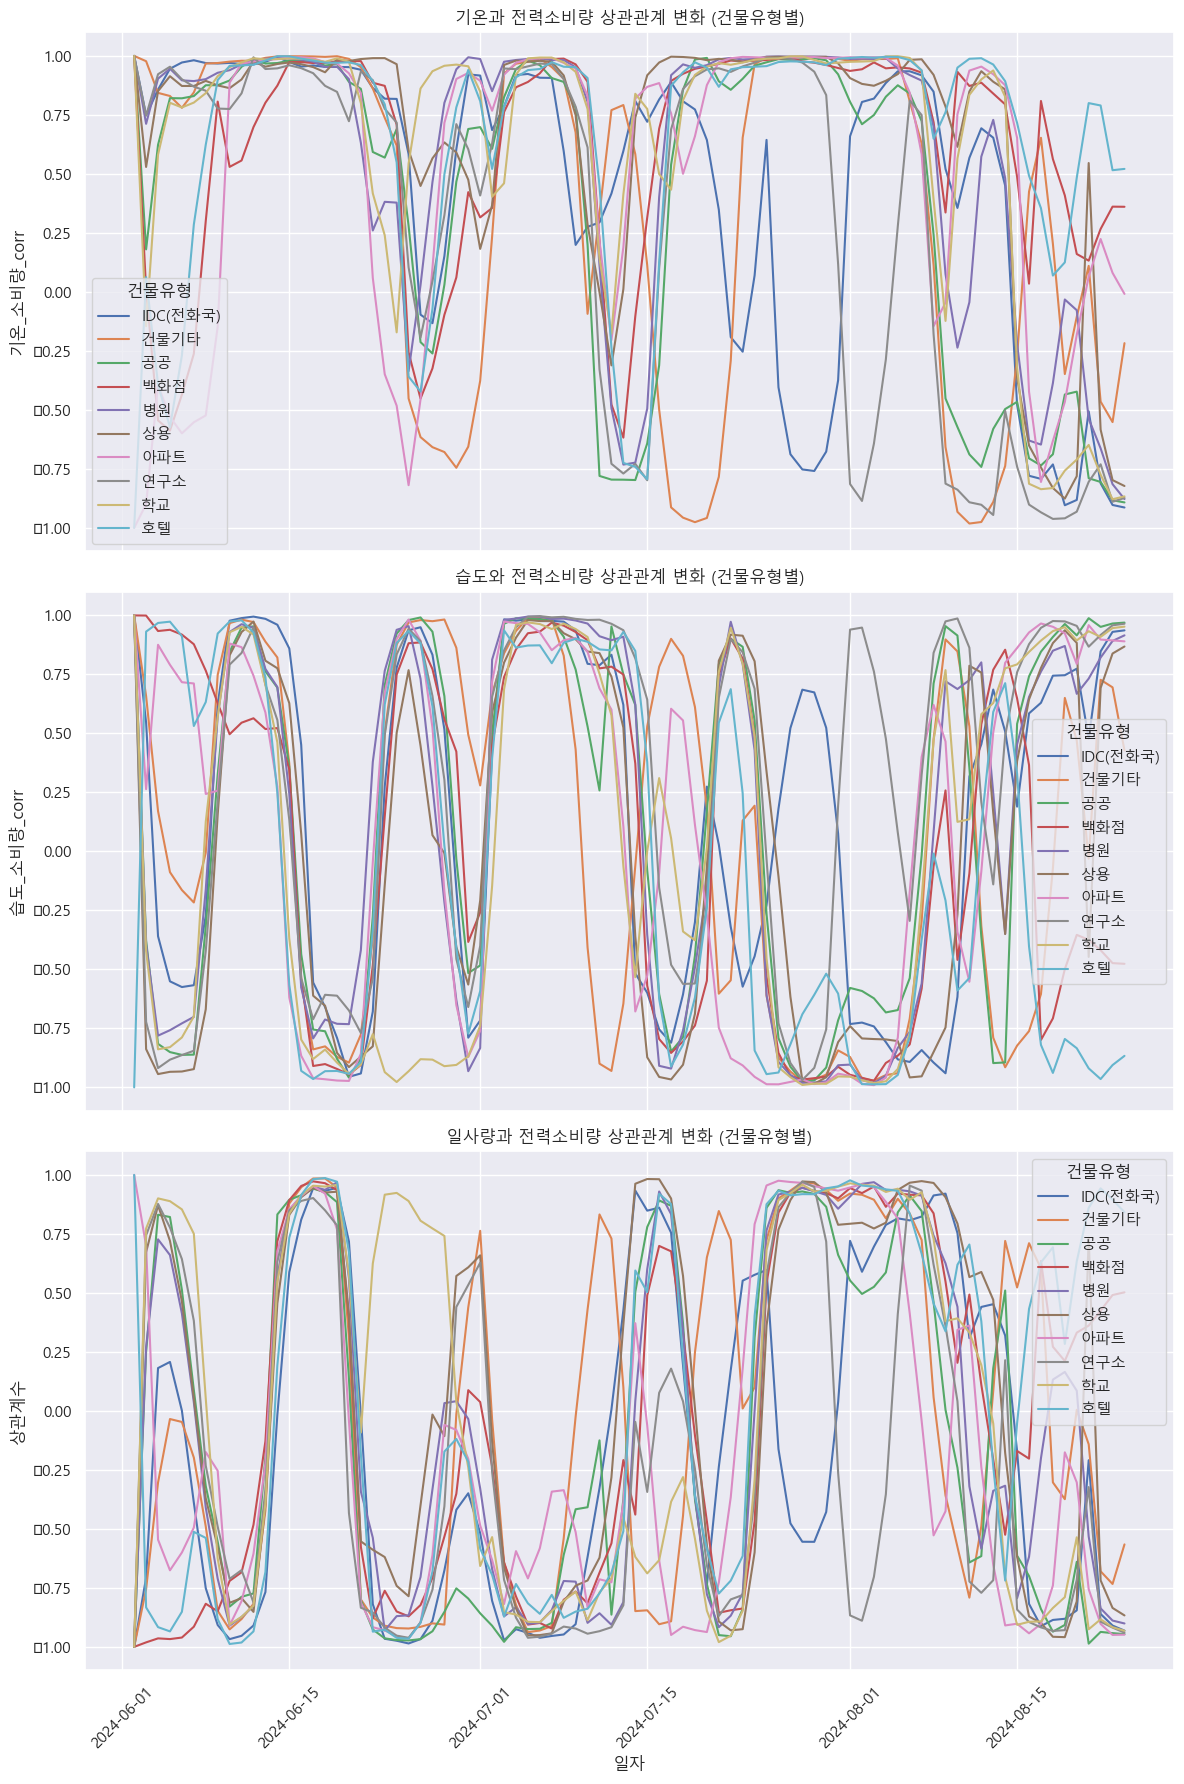

In [ ]:
# 기상 변수와 소비량의 상관관계 변화 (시계열 + 건물유형)
# 일일 평균 기온, 습도, 일사량 vs 전력소비량 → rolling correlation (7일 이동 상관계수 등)
# 건물유형별로 따로 계산

# 일자 오름차순 정렬 (rolling 계산을 위해)
t = train.groupby(['date_time', 'building_type']).agg({
    'power_usage': 'mean',
    'temperature': 'mean',
    'humidity': 'mean',
    'solar': 'mean'
}).reset_index().sort_values(['building_type', '일자'])

# 이동 평균 계산 (7일 이동)
t['전력소비량_이동평균'] = t.groupby('building_type')['power_usage'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
t['기온_이동평균'] = t.groupby('building_type')['temperature'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
t['습도_이동평균'] = t.groupby('building_type')['humidity'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
t['일사_이동평균'] = t.groupby('building_type')['solar'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# rolling correlation (7일 이동 상관계수)
def rolling_corr(x, y, window=7):
    return x.rolling(window, min_periods=1).corr(y)

t['기온_소비량_corr'] = t.groupby('building_type').apply(
    lambda df: rolling_corr(df['기온_이동평균'], df['전력소비량_이동평균'])
).reset_index(level=0, drop=True)
t['습도_소비량_corr'] = t.groupby('building_type').apply(
    lambda df: rolling_corr(df['습도_이동평균'], df['전력소비량_이동평균'])
).reset_index(level=0, drop=True)
t['일사_소비량_corr'] = t.groupby('building_type').apply(
    lambda df: rolling_corr(df['일사_이동평균'], df['전력소비량_이동평균'])
).reset_index(level=0, drop=True)

# 결과 시각화
fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
sns.lineplot(data=t, x='일자', y='기온_소비량_corr', hue='building_type', ax=ax[0])
ax[0].set_title('기온과 전력소비량 상관관계 변화 (건물유형별)')
sns.lineplot(data=t, x='일자', y='습도_소비량_corr', hue='building_type', ax=ax[1])
ax[1].set_title('습도와 전력소비량 상관관계 변화 (건물유형별)')
sns.lineplot(data=t, x='일자', y='일사_소비량_corr', hue='building_type', ax=ax[2])
ax[2].set_title('일사량과 전력소비량 상관관계 변화 (건물유형별)')
ax[2].set_xlabel('일자')
ax[2].set_ylabel('상관계수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

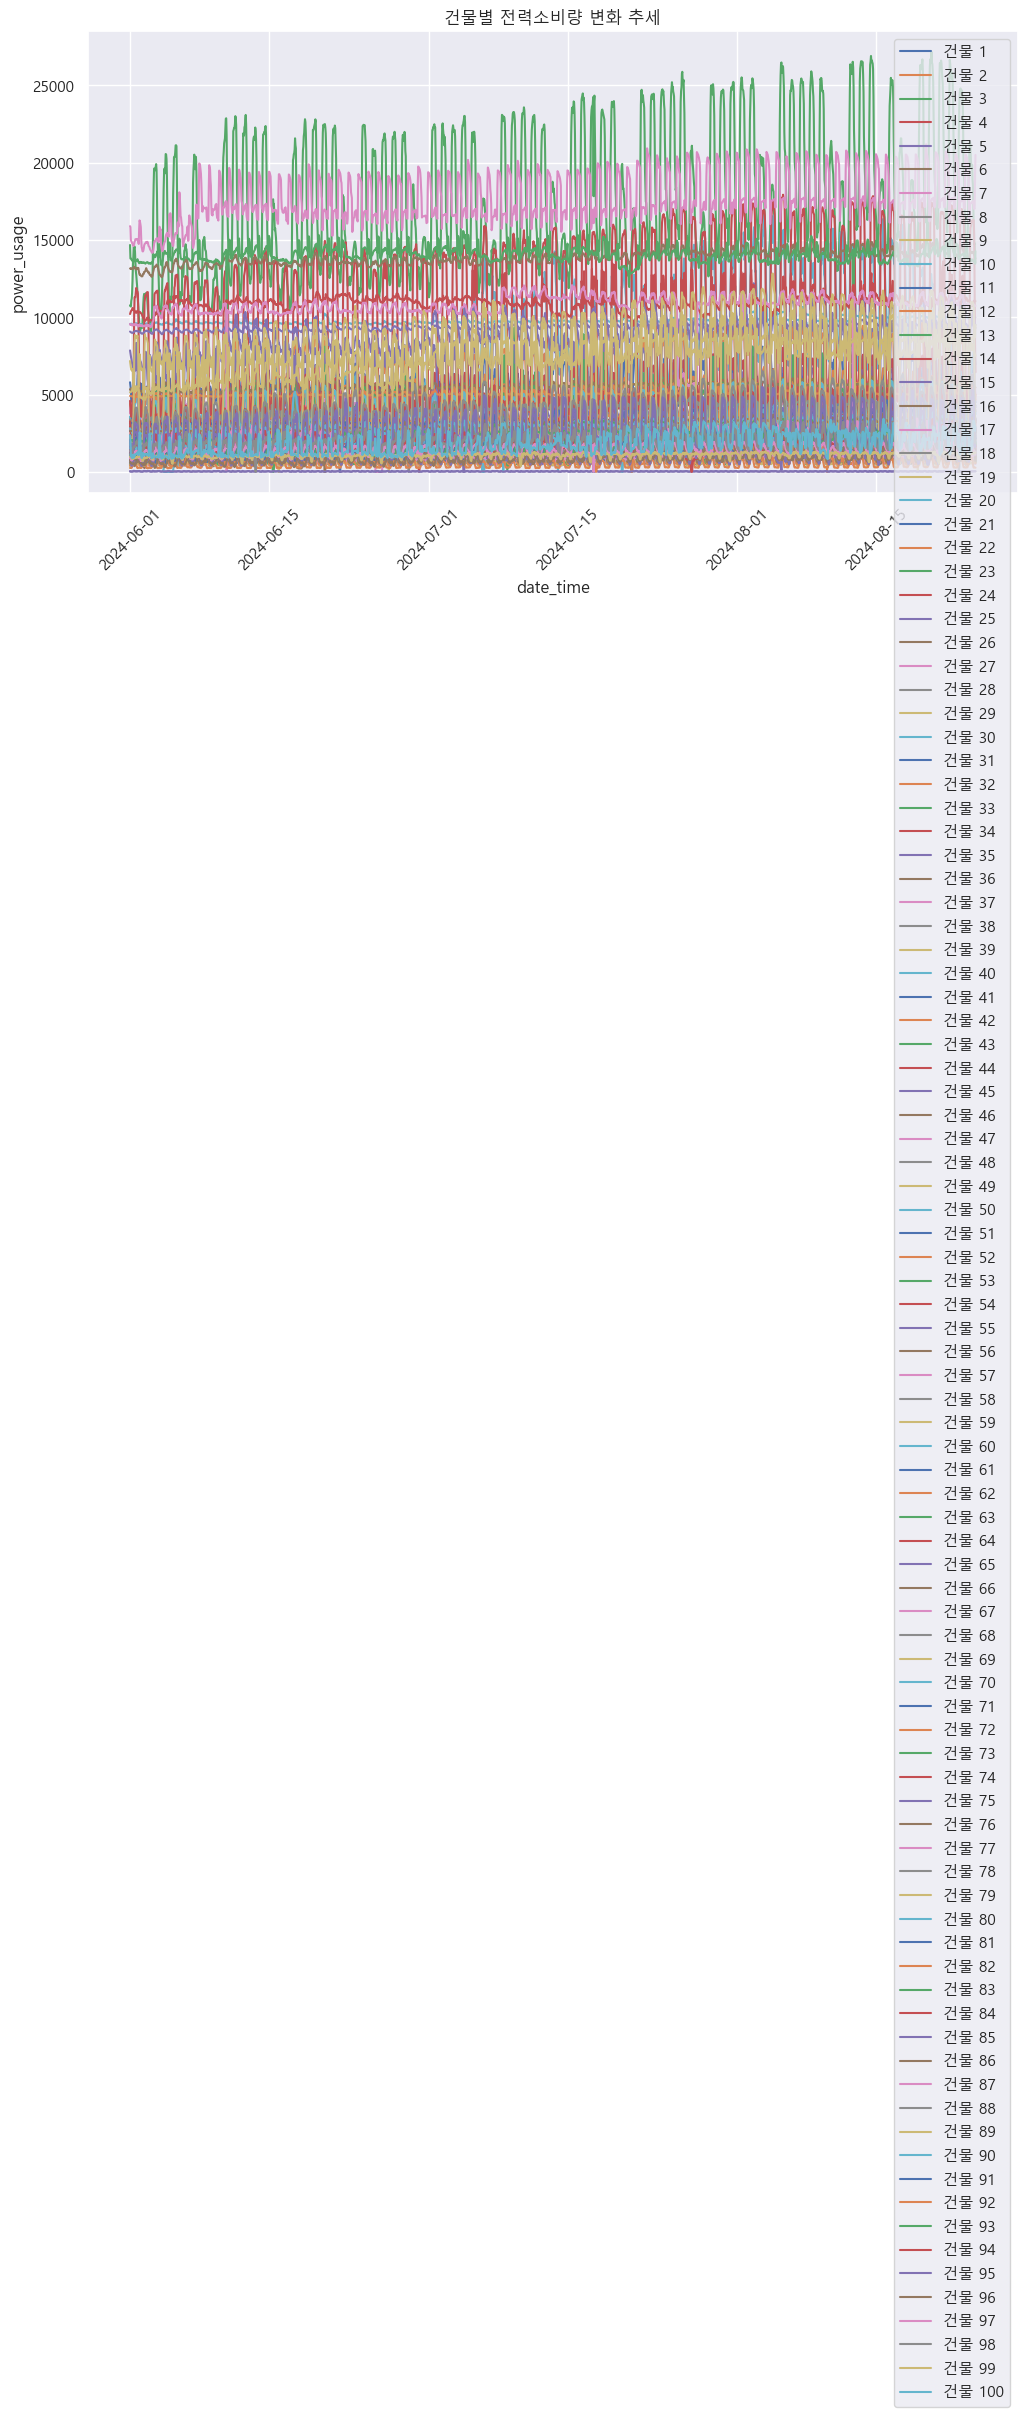

In [35]:
# 건물별 전력소비량 변화 추세
fig, ax = plt.subplots(figsize=(12, 6))
for building_num in train['building_num'].unique():
    building_data = train[train['building_num'] == building_num]
    sns.lineplot(data=building_data, x='date_time', y='power_usage', label=f'건물 {building_num}', ax=ax)
ax.set_title('건물별 전력소비량 변화 추세')
ax.set_xlabel('date_time')
ax.set_ylabel('power_usage')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# 전처리된 데이터 저장
print("전처리된 데이터를 저장합니다...")
preprocessor.save_processed_data()

# 이상치 탐지 (참고용)
print("\n=== 이상치 탐지 결과 ===")
outliers = preprocessor.detect_outliers(['power_usage', 'temperature', 'humidity'])
for col, indices in outliers.items():
    print(f"{col}: {len(indices)}개 이상치 탐지")

print(f"\n전체 이상치: {sum(len(indices) for indices in outliers.values())}개")
print("이상치 제거는 모델링 단계에서 필요에 따라 수행하세요.")

print("\n✅ 데이터 전처리 및 저장 완료!")